In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,silhouette_samples
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.inspection import DecisionBoundaryDisplay
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Short note about distances

While it might seem there is only one way to measure distance, there are in fact many ways of doing it. In most cases, we define distance by means of norms. Common family of norms are called "$L_p$-norms". Using them we define family of Minkowki's distances. In this case I will be using words distance and norm interchangeably. A norm of a vector is just a distance from a vector to the origin. The formula for $L_p$-norm of a vector ${\bf x}=(x_1, x_2, ..., x_n)$ is given by $$||{\bf x}||_p=\left(\sum_{i=1}^n |x_i^p| \right)^{1/p}$$

If you think carefully, you should see that $L_2$-norm is just a regular Euclidian distance. Moreover, L1-regularization and L2-regularization names come from this as well (check the formula for them). The most common norms you will see are $L_1$, $L_2$ and $L_{\infty}$ norms. The $L_{\infty}$-norm is just $||{\bf x}||_{\infty}=\max \{x_1, x_2, ..., x_n\}$.

Finally, to find distance between two vectors using $L_p$ norm we need to subtract given vectors and find the $L_p$-norm of the difference: $d_p({\bf x, y})=||{\bf x- y}||_p$.

Another interesting distance formula is "Cosine Distance" that measures the angle between vectors: $$d_c ({\bf x, y})=1-\frac{{\bf x \cdot y}}{||{\bf x}||\cdot ||{\bf y}||}$$
The norms in the formula are regular $L_2$-norms. Zero distance would mean vectors point in the same direction, and one would mean vectors are perpendicular and two would mean they point in opposite directions. This norm can be used in ChatGPT to determine words with similar meaning.


In the SVM chapter, we have discussed kernels. Kernel can be throught of as measuring similarity. The closer (more similar) two points are to each other the larger is the kernel. So, it is opposite of the distance. But, because it is exact opposite, it can be used to define distances as well. For example, RBF kernel is very useful in this sense.

### KNN

KNN (K nearest neighbor) is a supervised algorithm that uses all of the data to determine classification of a given datapoint by checking K nearest neighbors. The idea behind it is quite simple: we assume that similar data points are grouped closer together. This idea is used in alot of other algorithms. Also, as you can see we need to use idea of distance here. Both $L_1$ and $L_2$ norms can be used (other distances can be used depending on data). Generally, for high dimensional data, $L_1$ performs better.

The good properties of KNN are that it is easy to use and understand. It handles image data quite well. However, it suffers form curse of dimensionality: too many dimension lead to overfitting. Moreover, it doesnt create a model, instead each time we need to make prediction, we need to look at the entire data set.

Let's see how it works on Iris data set. Let's first see what K should we pick. If K is too small we will overfit, while if it is too large we will underfit. Normally, we use cross-validation to test some of the values.

In [2]:
dataset=datasets.load_iris()
X = dataset.data
y = dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [3]:
param_dist  = {
              'n_neighbors': np.arange(1,20,1),
              'metric' :[ 'l1', 'l2', 'cosine']
             }

model = KNeighborsClassifier()
tree_cv = GridSearchCV(model, param_dist, cv=5)

tree_cv.fit(X_train, y_train)
print("Tuned KNN Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned KNN Parameters: {'metric': 'cosine', 'n_neighbors': 14}
Best score is 0.9916666666666666


Note that values might be different for you since the train/test data split can be different. Let's use these values

In [4]:
knn=KNeighborsClassifier(n_neighbors=6, metric='l2')
knn.fit (X_train, y_train)

KNeighborsClassifier(metric='l2', n_neighbors=6)

In [5]:
predictions = knn.predict(X_test)
accuracy_score(y_test, predictions)

0.9666666666666667

Here is an example with custom distance using RBF (Notice we are subtracting RBF kernel from 1 to make it behave as distance):

In [6]:
def metricrbf(x,y):
    return 1-np.exp(-1*np.linalg.norm(x-y)**2/2)

knnrbf=KNeighborsClassifier(n_neighbors=6,
                 metric=metricrbf
                 )
knnrbf.fit(X_train, y_train)

KNeighborsClassifier(metric=<function metricrbf at 0x000001C654575080>,
                     n_neighbors=6)

In [7]:
predictions = knnrbf.predict(X_test)
accuracy_score(y_test, predictions)

0.9666666666666667

KNN can be used for regression problems as well. In this case, we find the average of K nearest neighbors.

### Clustering

Clustering is a family of algorithms that try to classify data when we dont have labels( i.e. these are unsupervised algorithms). We will look at two common algorithms: K-means and Spectral clustering. We will apply them on three types of random data.

Before we get into clustering, I need to mention the biggest drawback of these types of algorithms. We don't know how many clusters we should have, so we need to set it to something based on visual examination, understanding given data, etc.

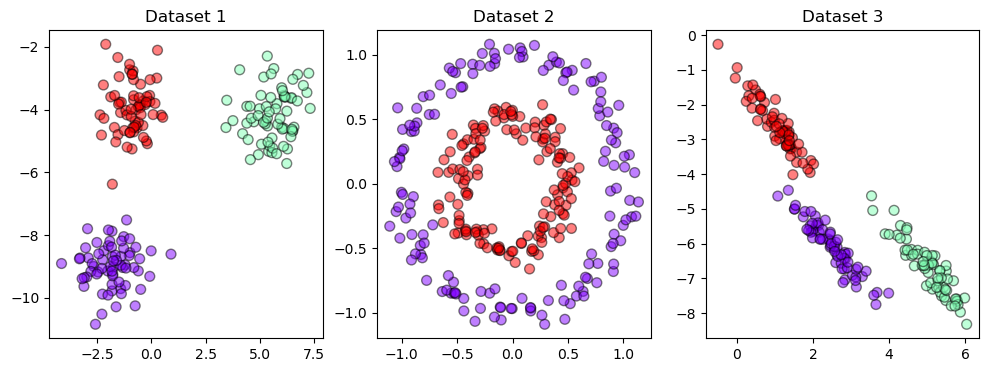

In [8]:
X1, y1 = make_blobs(n_samples=200, centers=3,random_state=40, cluster_std=0.8)   
X2, y2  = make_circles(n_samples=300, factor=.5, noise=.08)
T=np.array([[0.6, -0.6],[-0.4, 0.8]])
X3=np.dot(X1,T)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='rainbow', edgecolor='black',alpha=.5)
ax1.set_title("Dataset 1")
ax2.scatter(X2[:, 0], X2[:, 1], c=y2, s=50, cmap='rainbow', edgecolor='black',alpha=.5)
ax2.set_title("Dataset 2")
ax3.scatter(X3[:, 0], X3[:, 1], c=y1, s=50, cmap='rainbow', edgecolor='black',alpha=.5)
ax3.set_title("Dataset 3")
plt.show()

### K-means

K-means clustering works as follows:

1. Set number of clusters K we want to have and randomly pick K points as centers of our clusters.
2. Classify all data by distance to nearest center.
3. Find means of each clusters and make them our new centers.
4. Repeat steps 2,3 until some stopping critieria is met.

K-means works well if our clusters are linearly separable round blobs. However, it has problems with outliers, high dimension, badly normalized data.

Let's apply K-means clustering on our three data sets. We, of course, will not be using labels. Instead, we will choose number clusters we want to have. We will choose number of cluster 2, 3 and 4 in each case.

In [9]:
classifiers_x1=[
    KMeans(n_clusters=2, random_state=0, n_init="auto"),
    KMeans(n_clusters=3, random_state=0, n_init="auto"),
    KMeans(n_clusters=4, random_state=0, n_init="auto")]
    
classifiers_x2=[
    KMeans(n_clusters=2, random_state=0, n_init="auto"),
    KMeans(n_clusters=3, random_state=0, n_init="auto"),
    KMeans(n_clusters=4, random_state=0, n_init="auto")]
    
classifiers_x3=[
    KMeans(n_clusters=2, random_state=0, n_init="auto"),
    KMeans(n_clusters=3, random_state=0, n_init="auto"),
    KMeans(n_clusters=4, random_state=0, n_init="auto")]

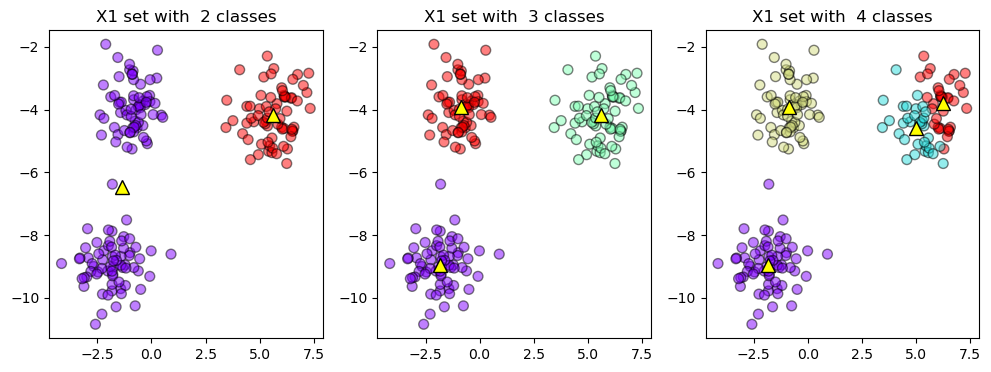

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
i=0
for classifier in classifiers_x1:    
    y_pred=classifier.fit_predict(X1)
    k_means_cluster_centers = classifier.cluster_centers_
    
    ax[i].scatter(X1[:, 0], X1[:, 1], 
                s=50, c=y_pred,cmap='rainbow',edgecolors="k",alpha=.5)
    ax[i].plot(
        k_means_cluster_centers[:,0],
        k_means_cluster_centers[:,1],
        "^",
        markerfacecolor="yellow",
        markeredgecolor="k",
        markersize=10,
    )
    ax[i].set_title(f'X1 set with  {i+2} classes')
    i+=1

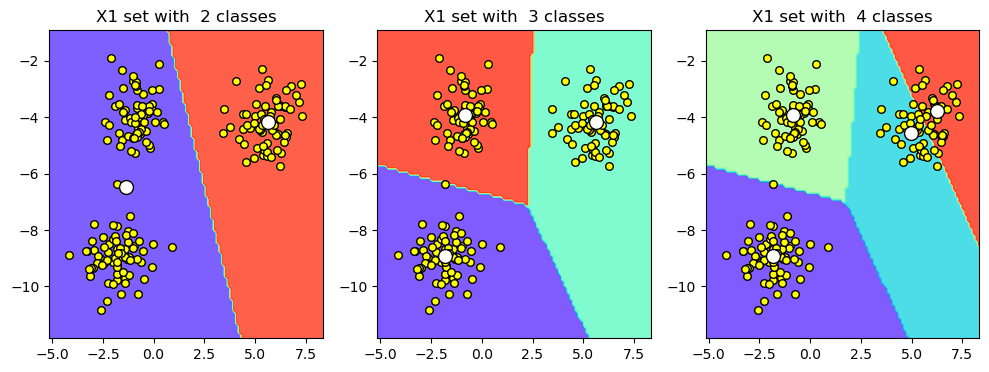

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
i=0
for classifier in classifiers_x1:
    classifier.fit(X1)
    k_means_cluster_centers = classifier.cluster_centers_
    disp=DecisionBoundaryDisplay.from_estimator(
            classifier,
            X1,
            response_method="predict",
            cmap=plt.cm.rainbow,
            alpha=0.8,
            ax=ax[i]
        )
    disp.ax_.plot(
        k_means_cluster_centers[:,0],
        k_means_cluster_centers[:,1],
        "o",
        markerfacecolor="w",
        markeredgecolor="k",
        markersize=10,
    )
    disp.ax_.scatter(X1[:, 0], X1[:, 1], 
                s=30, c='yellow', cmap='rainbow',edgecolors="k")
    ax[i].set_title(f'X1 set with  {i+2} classes')
    i+=1

plt.show()

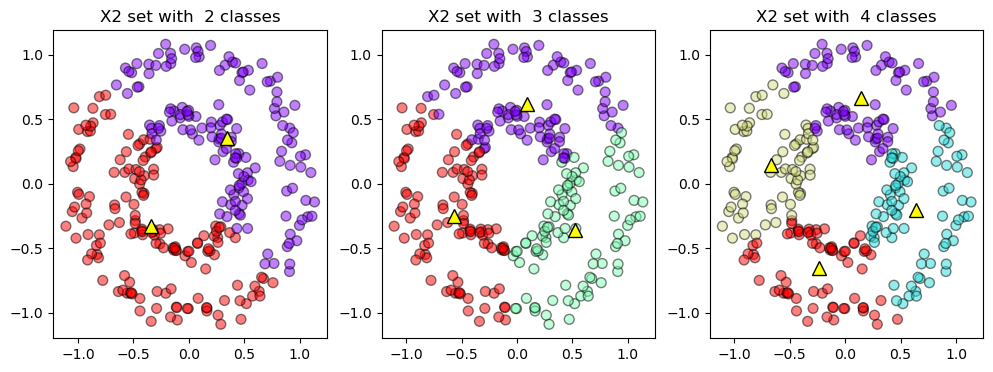

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
i=0
for classifier in classifiers_x2:    
    y_pred=classifier.fit_predict(X2)
    k_means_cluster_centers = classifier.cluster_centers_
    
    ax[i].scatter(X2[:, 0], X2[:, 1], 
                s=50, c=y_pred,cmap='rainbow',edgecolors="k",alpha=.5)
    ax[i].plot(
        k_means_cluster_centers[:,0],
        k_means_cluster_centers[:,1],
        "^",
        markerfacecolor="yellow",
        markeredgecolor="k",
        markersize=10,
    )
    ax[i].set_title(f'X2 set with  {i+2} classes')
    i+=1

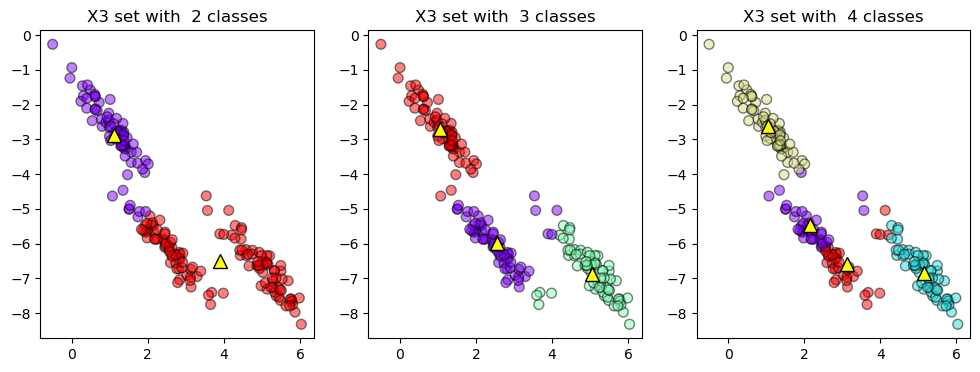

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
i=0
for classifier in classifiers_x3:    
    y_pred=classifier.fit_predict(X3)
    k_means_cluster_centers = classifier.cluster_centers_
    
    ax[i].scatter(X3[:, 0], X3[:, 1], 
                s=50, c=y_pred,cmap='rainbow',edgecolors="k",alpha=.5)
    ax[i].plot(
        k_means_cluster_centers[:,0],
        k_means_cluster_centers[:,1],
        "^",
        markerfacecolor="yellow",
        markeredgecolor="k",
        markersize=10,
    )
    ax[i].set_title(f'X3 set with  {i+2} classes')
    i+=1

### Spectral Clustering

As you can see K-means worked best when the data is (almost) linearly separable and "blobby". We need a better clustering algorithm to deal with last two cases. So, we will look at spectral clustering next.

This method is a lot more advanced. The idea is as follows:
1. We choose how many clusters we want to have (K)
2.  We define a similarity measure on our points, where it is small if points are far and big if points are close (often RBF or KNN is used here)
3. We define a cost function  that uses similarity measures and a given classification to determine how good is this classification. (This function will end up being a symmetric matrix)
4. We would want to minimize our cost function. The solution will involve eigenvectors (hence the name "spectral").
5. We will form a matrix whose columns are K smallest eigenvectors and apply K-means on rows of this matrix to get final classification.

We will then add a modification:

1. We will normalize our cost function, that will change our minimization problem into maximization problem.
2. We will normalize rows of a matrix consisting of K largest eigenvectors before applying K-means classification.


Now let's look at these steps in more detail. Suppose we have a set $X=\{ {\bf x_1, x_2, ... ,x_n}\}$ of n vectors. We as usual consider these vectors as n points in some space. We define a adjacency matrix $W=[ w_{ij}]$, where each entry $w_{ij}$ is similarity factor between ${\bf x_i}$ and ${\bf x_j}$ that we get through RBF kernel (other kernels can be used as well but RBF is most popular). Note that few things about $W$:

1. $W$ is symetric. (i.e. $w_{ij}=w_{ji}$)
2. The name adjacency comes from the fact that we are looking at our points as a graph, where if points are close ( similarity is large) then we have an edge between them creating a cluster.

We define degree $d_i$ of a point ${\bf x_i}$ as a sum of all values in the $i$-th row of $W$ matrix, and form a diagonal degree matrix $D$ with $d_i$ values along its main diagonal.

Suppose we are given some clustering matrix, where each row corresponds to one of out data points and consists of zeros and a single 1 in the column corresponding to which cluster it belongs (think one-hot encoding). We then define a matrix $Y$ where we normalize each column of clustering matrix to have norm 1 (This is done to simplify future optimization problem. Note that $Y^TY=I$ now). We want to define a function that measures how strong the relationship is between clusters. Since we have measure on relationship between each pair points, we can use that to determine relatinship between clusters. The function that is often used for this is

$$ R=\sum_{i,j} w_{ij}||{\bf y_i}- {\bf y_j}||^2$$

where ${\bf y_i}$ is the i-th row of $Y$. Notice that

1. if ${\bf y_i}$ and ${\bf y_j}$ are in the same cluster, then $w_{ij}||{\bf y_i}- {\bf y_j}||^2=0$;
2. if ${\bf y_i}$ and ${\bf y_j}$ are in the different cluster, then $w_{ij}||{\bf y_i}- {\bf y_j}||^2 = Cw_{ij}$, for some $C>0$
3. the smaller $R$ is, the weaker is the relationship between clusters and so given clustering is better.

So we would like to minimize $R$; in other words find 

$$\begin{equation}
\begin{aligned}
\underset{Y}{\operatorname{argmin}}\sum_{i,j} w_{ij}||{\bf y_i}- {\bf y_j}||^2 &  =  \underset{Y}{\operatorname{argmin}}\sum_{i,j} w_{ij}({\bf y_i}\cdot {\bf y_i}-2{\bf y_i}\cdot {\bf y_j}+{\bf y_j}\cdot {\bf y_j})\\
& = \underset{Y}{\operatorname{argmin}}\sum_{i,j} w_{ij}{\bf y_i}\cdot {\bf y_i}-2\sum_{i,j}w_{ij}{\bf y_i}\cdot {\bf y_j}+\sum_{i,j}w_{ij}{\bf y_j}\cdot {\bf y_j} \\
& = \underset{Y}{\operatorname{argmin}} 2 \sum_{i,j} w_{ij}{\bf y_i}\cdot {\bf y_i}-2\sum_{i,j}w_{ij}{\bf y_i}\cdot {\bf y_j}\\
\end{aligned}
\end{equation}$$

We can drop 2, and we can also show that the first sum can be rewritten as $Y^TDY$ and the second sum as $Y^TWY$. So our final minimization problem is

$$\begin{equation}
\begin{aligned}
\underset{Y}{\operatorname{argmin}}\sum_{i,j} w_{ij}||{\bf y_i}- {\bf y_j}||^2 &  = \underset{Y}{\operatorname{argmin}} Y^TDY - Y^TWY\\
& = \underset{Y}{\operatorname{argmin}} Y^T(D - W)Y
\end{aligned} 
\end{equation}$$

Let $L=D-W$. This matrix is often called Laplacian. To minimize $Y^TLY$ we need to find eigenvalues of $L$ and pick K eigenvectors corresponding to smallest eigenvalues to form matrix $U$. (if you are familiar with SVD, this is truncated SVD, except we are picking smallest eigenvalues instead of largest ones). We can then apply K-means on rows of $U$ to get final clustering.

If we apply this method as is, it should work ok, but sometimes we can run into scaling problem, when values get too large. So, in reality we generally use modification of this called normalized spectral clustering. For that, we change our $L$ matrix to $L_s=D^{-1/2}LD^{-1/2}$. This leads to the following optimization:

$$\begin{equation}
\begin{aligned}
\underset{Y}{\operatorname{argmin}}Y^TL_sY & = \underset{Y}{\operatorname{argmin}}Y^TD^{-1/2}LD^{-1/2}Y \\
& = \underset{Y}{\operatorname{argmin}}Y^TD^{-1/2}(D-W)D^{-1/2}Y\\
& = \underset{Y}{\operatorname{argmin}}Y^TD^{-1/2}DD^{-1/2}Y-Y^TD^{-1/2}WD^{-1/2}Y\\
& = \underset{Y}{\operatorname{argmin}}Y^TY-Y^TD^{-1/2}WD^{-1/2}Y\\
& = \underset{Y}{\operatorname{argmin}}-Y^TD^{-1/2}WD^{-1/2}Y\\
& = \underset{Y}{\operatorname{argmax}}Y^TD^{-1/2}WD^{-1/2}Y\\
\end{aligned} 
\end{equation}$$

Now we can do the same process as before except instead of picking smallest eigenvalues, we are picking largest eigenvalues.

Finally, before applying K-means, it is helpful to normalize our matrix $U$ as well.

In [14]:
def rbf_kernel(X, gamma=1.0):
    pairwise_sq_dists = np.sum((X[:, np.newaxis] - X[np.newaxis, :]) ** 2, axis=2)
    return np.exp(-gamma * pairwise_sq_dists)

W = rbf_kernel(X3, gamma=5)
D = np.diag(np.sum(W, axis=1))
L = D - W
D_inv_sqrt = np.diag(1/np.sqrt(np.diag(D)))
Lambdas, V = np.linalg.eig(np.matmul(np.matmul(D_inv_sqrt, W), D_inv_sqrt))

In [15]:
K=3
# Sort the eigenvalues by their L2 norms and record the indices
ind = np.argsort(np.linalg.norm(np.reshape(Lambdas, (1, len(Lambdas))), axis=0))
V_K = np.real(V[:, ind[-K:]])
# Normalize the row sums to have norm 1
V_K = V_K/np.reshape(np.linalg.norm(V_K, axis=1), (V_K.shape[0], 1))

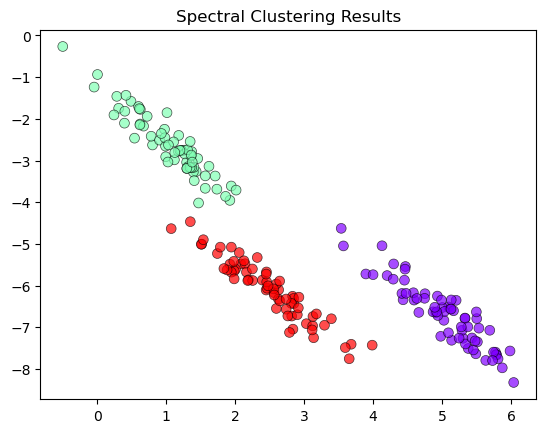

In [17]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=K)
kmeans.fit(V_K)
labels = kmeans.labels_

# Plot the results
plt.scatter(X3[:, 0], X3[:, 1], c=labels, s=50, cmap='rainbow', lw=0.5, edgecolor='k',alpha=.7)
plt.title("Spectral Clustering Results")
plt.show()

Let's applying to all sets. This time I will choose wanted amount of clusters, but change the hyperparameter.

In [18]:
classifiers_x1=[
    SpectralClustering(n_clusters=3, affinity='nearest_neighbors'),
    SpectralClustering(n_clusters=3, affinity='rbf', gamma=5),
    SpectralClustering(n_clusters=3, affinity='rbf', gamma=40)]
    
classifiers_x2=[
    SpectralClustering(n_clusters=2, affinity='nearest_neighbors'),
    SpectralClustering(n_clusters=2, gamma=10),
    SpectralClustering(n_clusters=2, gamma=100)]
    
classifiers_x3=[
    SpectralClustering(n_clusters=3, affinity='nearest_neighbors'),
    SpectralClustering(n_clusters=3, gamma=1),
    SpectralClustering(n_clusters=3, gamma=5)]

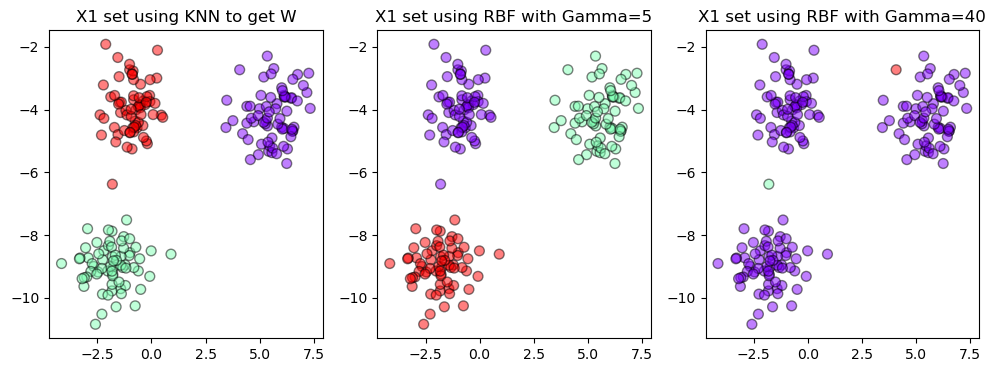

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
i=0
g=[5,40]
for classifier in classifiers_x1:    
    y_pred=classifier.fit_predict(X1)
    
    ax[i].scatter(X1[:, 0], X1[:, 1], 
                s=50, c=y_pred,cmap='rainbow',edgecolors="k",alpha=.5)

    if i==0:
        ax[i].set_title(f'X1 set using KNN to get W')
    else:
        ax[i].set_title(f'X1 set using RBF with Gamma={g[i-1]}')
    i+=1

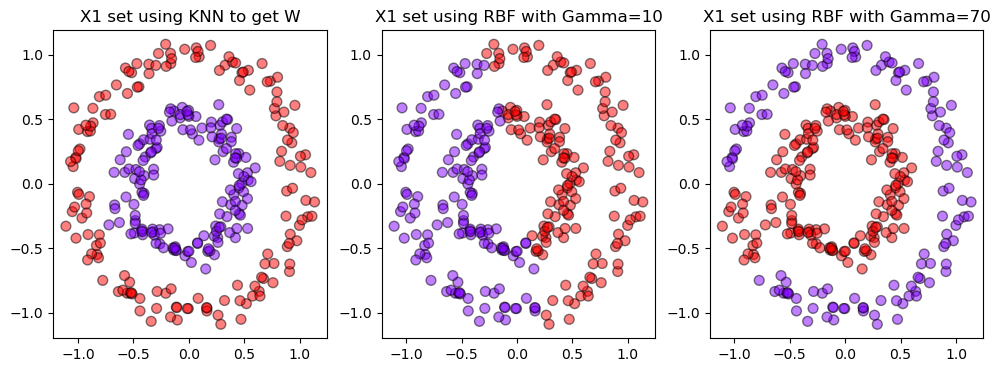

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
i=0
g=[10,70]
for classifier in classifiers_x2:    
    y_pred=classifier.fit_predict(X2)
    
    ax[i].scatter(X2[:, 0], X2[:, 1], 
                s=50, c=y_pred,cmap='rainbow',edgecolors="k",alpha=.5)
 
    if i==0:
        ax[i].set_title(f'X1 set using KNN to get W')
    else:
        ax[i].set_title(f'X1 set using RBF with Gamma={g[i-1]}')
    i+=1

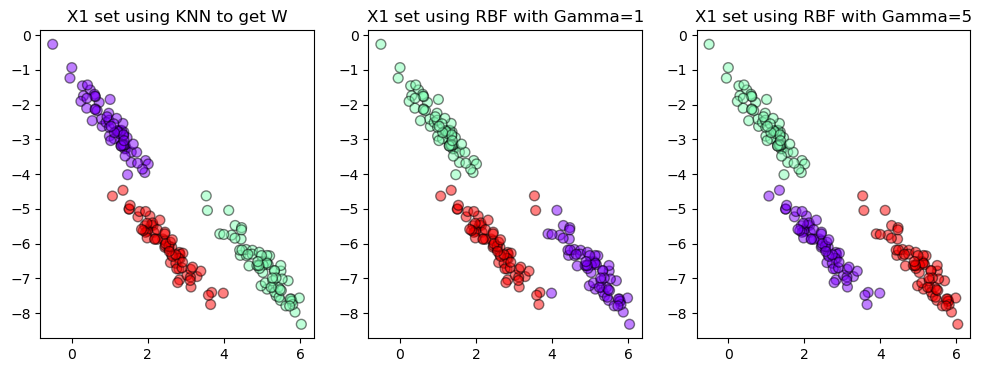

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
i=0
g=[1,5]
for classifier in classifiers_x3:    
    y_pred=classifier.fit_predict(X3)
    
    ax[i].scatter(X3[:, 0], X3[:, 1], 
                s=50, c=y_pred,cmap='rainbow',edgecolors="k",alpha=.5)
 
    if i==0:
        ax[i].set_title(f'X1 set using KNN to get W')
    else:
        ax[i].set_title(f'X1 set using RBF with Gamma={g[i-1]}')
    i+=1

Advantage of spectral clustering is that we do not assume that our clusters a round blobs and it works reasonably well on strange shapes.
Drawback is that it is computationaly heavy especially for large data sets as computing eigenvectors and eigenvalues is not simple. Also, we still need to choose amount of clusters.


There are many more clustering algorithms. You should look through https://scikit-learn.org/stable/modules/clustering.html to see how they perform and how they work. The ones worth noting are:
1. Hierarchical clustering: works great on small data sets, but not so good on large
2. Density methods (DBScan and HDBScan): these create clusters based on density of points. Automatically determine number of clusters.

### How to determine how many clusters we should have?

In general, we need to specify how many clusters we want to have. In our examples, we could tell by looking at the scatter plot, but usually our data is not so nice. There are few ways that we can use to give us an idea how many clusters we should have. We will look at elbow plot and silhouette plot.

1. Elbow plot.

We can compute within cluster distorion (SSE or sum of squares error):
$$ \sum_{k=1}^K \sum_{i=1}^{n_k}\left(x_i-\overline{x}_k\right)$$ 
where $K$ is number of clusters, $n_k$ is amount of points in cluster $k$ and $\overline{x}_k$ is mean in cluster $k$.  Note, this means this works only for K-means.


As we increae amount of clusters, within cluster diststortion will go down since more points will be closer to their mean. A good choice for $K$ will be a point where this descrease slows down. Let's look at the example:

In [34]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
    n_init='auto',
    random_state=0)
    km.fit(X3)
    distortions.append(km.inertia_)   # .inertia_ computes the within cluster distortion

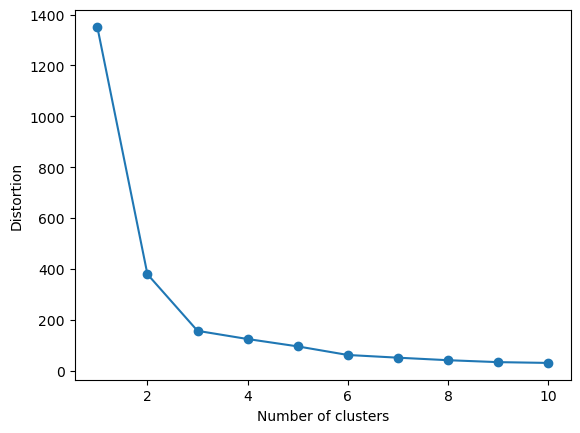

In [35]:
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

This plot suggests that we should have 3 clusters, which is what we did have.

2. Silhouette plot.

This plot would work for other clustering algorithms. It works as follows:

1. Find cluster cohesion ($a_i$) for each point, which is average of distance between given point and other points in the same cluster. So, for a point $x_i$ from cluster $C_k$ we have: $$ a_i=\frac{1}{n_k}\sum_{j=1}^{n_k}||x_i-x_j||$$
2. Find cluster separation ($b_i$) for each point, an average distance between given point and points from closest other cluster. So, for a point $x_i$ from cluster $C_k$ we have: $$ b_i=\min_{C_j \neq C_k} \left(\frac{1}{n_j}\sum_{i=1}^{n_j}||x_i-x_j||\right)$$
3. Combine results to get Silhouette Value:
   $$s_i=\frac{b_i-a_i}{\max(a_i, b_i)}$$.


What do we want to see? For a given point $x_i$, we want $b_i$ to be much larger than $a_i$, which means we would want $s_i$ to be closer to 1. So, we want the average of all silhouette values to be closer to 1. 

Let's apply it to our example:

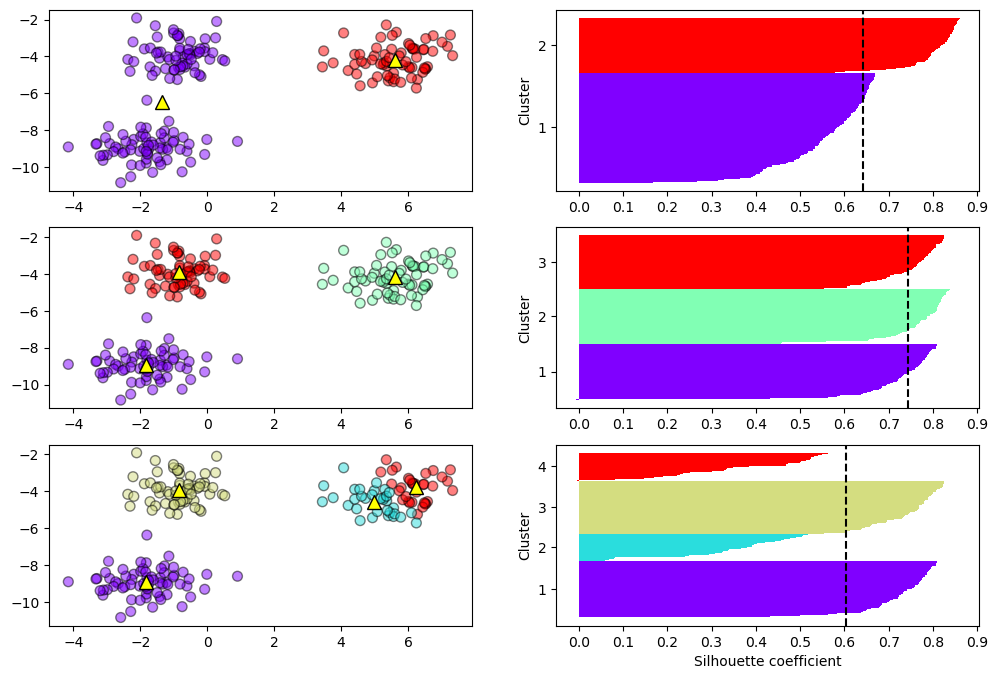

In [112]:
fig, ax = plt.subplots(3, 2, figsize=(12, 8), sharex='col')
i=0
for classifier in classifiers_x1:    
    y_pred=classifier.fit_predict(X1)
    k_means_cluster_centers = classifier.cluster_centers_
    cluster_labels = np.unique(y_pred)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X1, y_pred, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    
    ax[i,0].scatter(X1[:, 0], X1[:, 1], 
                s=50, c=y_pred,cmap='rainbow',edgecolors="k",alpha=.5)
    ax[i,0].plot(
        k_means_cluster_centers[:,0],
        k_means_cluster_centers[:,1],
        "^",
        markerfacecolor="yellow",
        markeredgecolor="k",
        markersize=10,
    )


    for n, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_pred == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = plt.cm.rainbow(float(n) / (n_clusters-1))
        ax[i,1].barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    ax[i,1].axvline(silhouette_avg,
        color="k",
        linestyle="--")
    ax[i,1].set_yticks(yticks, cluster_labels + 1)
    ax[i,1].set_ylabel('Cluster')
    i+=1

ax[2,1].set_xlabel('Silhouette coefficient')
ax[2,1].set_xticks(np.arange(0,1,0.1))
for ax in ax.flatten():
    ax.xaxis.set_tick_params(labelbottom=True)
plt.show()



Looking at our three plots we see that 3 classes is the best choice.